### Lesson 03 Assignment

This notebook simulates the conditional probabilities of the distributions for winning a car vs. a goat for the Monty Hall Problem that includes the following:
1. the cases of switching or not switching
2. histograms and summary statistics (at least mean and variance) of the results for winning the car or a goat for both strategies, switching or not switching
3. comparison of the cases to determine the best strategy
4. recommended strategy

#### Preliminaries

Import the required libraries and define some notebook settings:

In [481]:
# Import required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from itertools import groupby
from matplotlib import pyplot

# Permit display of all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Declare constants for the number of games per sample and number of samples:

In [482]:
GAMES_PER_SAMPLE = 100
NUMBER_OF_SAMPLES = 10

#### The Monte Hall Problem

The Monte Hall Problem works as follows:
- The problem begins with three closed doors: Behind one of the doors is a car, behind the others is a goat.
- The host, Monte Hall, presents a contestant with the opportunity to guess which door has the car. If the contestant guesses correctly, s/he wins the car. Otherwise, s/he wins a goat (a prize that presumably s/he would simply decline).
- The contestant then chooses one of the closed doors, after which Monte opens one of the other two remaining doors, revealing a goat.
- Monte offers the contestant a choice between staying with the door they initially guessed or switching to the other closed door.
- Monte then opens the contestant's chosen door, revealing the contestant's prize, either a car or a goat.

By opening one of the doors, is Monte generously supplying additional useful information that improves the chances that the contestant will win? Or is he simply teasing the contestant to make good TV? Our job is to find out.

### Probabilities and Distributions

First we consider the sources of uncertainty and the distributions of potential outcomes behind the Monte Hall problem in order to devise an appropriate simulator.

##### Contestant's Initial Guess

On their initial guess, the contestant has a probability of 1/3 that they will choose the door with the car, because there are three doors, only one of which has the car, and the contestant has no additional information. This is an independent probability that we can model using the following function *sim_door*:

In [483]:
# in the 3-door simulation, doors are randomly chosen with equal probability from 3 doors
# when pval is approximately 0.333, this is a multinomial distribution
door_probas = [
      .333,  # door 1
      .333,  # door 2
      .333,  # door 3
  ]

# Param 1 door_probas: list of probabilities that a given door will be selected
# Returns: independent selection of one door out of three
# randomly select one door out of three possible doors
# used for placing the car behind one door and the contestant's selection of one door
def sim_door(door_probas):
    return list(zip(
        ['door 1', 'door 2', 'door 3'], 
        np.random.multinomial(1, door_probas)))

We can examine the distribution of outcomes by running multiple trials (e.g. 100) of *sim_door* over a large number of iterations (e.g. 1000):

In [484]:
# perform n trials of sim_door
def run_door_outcomes(num_games):
    return pd.Series(Counter([[t[0] for t in sim_door(door_probas) if t[1] == 1][0] \
                              for i in range(0, num_games)])).sort_index()

# derive m samples of n trials of sim_door
def run_door_samples(num_samples, num_games):
    return pd.DataFrame([run_door_outcomes(num_games) for i in range(0, num_samples)])

run_door = run_door_samples(1000, 100)
run_door

,door 1,door 2,door 3
0,32,35,33
1,29,34,37
2,22,40,38
3,32,39,29
4,29,44,27
...,...,...,...
995,33,42,25
996,37,20,43
997,35,32,33
998,32,27,41


We compute the mean times selected per door out of 100 trials:

In [485]:
run_door_mean = run_door.mean()
run_door_mean

door 1    33.492
door 2    33.248
door 3    33.260
dtype: float64

We compute the variance of the times selected per door out of 100 trials:

In [486]:
run_door_var = run_door.var()
run_door_var

door 1    23.185121
door 2    21.854350
door 3    22.532933
dtype: float64

The histogram reveals that the most common outcome for a particular door, in this case 'door 1', in a set of 1000 trials of 100 simulations is between 33 and 35 out of 100:

(array([  2.,   3.,   4.,  20.,  27.,  67.,  27.,  50.,  68.,  82., 131.,
         97.,  86.,  73.,  58.,  97.,  36.,  28.,  17.,  10.,  10.,   1.,
          2.,   2.,   2.]),
 array([20. , 21.2, 22.4, 23.6, 24.8, 26. , 27.2, 28.4, 29.6, 30.8, 32. ,
        33.2, 34.4, 35.6, 36.8, 38. , 39.2, 40.4, 41.6, 42.8, 44. , 45.2,
        46.4, 47.6, 48.8, 50. ]),
 <a list of 25 Patch objects>)

Text(0.5, 1.0, "Distribution of outcomes for 'door 1' out of 3 doors in 1000 trials of 100 simulations")

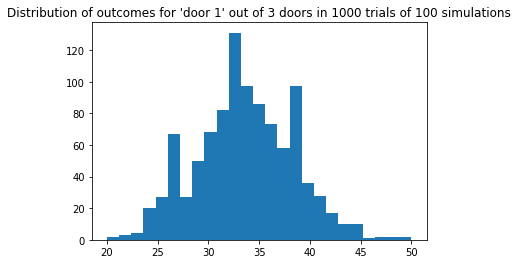

In [504]:
# histogram of samples of trials
pyplot.hist(run_door['door 1'], bins=25)
pyplot.title('Distribution of outcomes for \'door 1\' out of 3 doors in 1000 trials of 100 simulations')

##### After Contestant's Initial Guess

After the contestant's initial guess, Monte may or may not have some constraints on which of the remaining doors he can open, so we have some conditional probabilities.

##### Case 1: Contestant Chooses Right, Monte Can Open Either Remaining Door

If the contestant initially picks the door with the car, Monte has no constraints on which door he can open: since neither of the remaining doors has a car, Monte can open either of the remaining doors with 1/2 probability, revealing a goat. Since this occurs in 1/3 of cases, we have a 1/2 * 1/3 = 1/6 probability of each of these scenarios. In the case where the contestant does not switch, this is their only chance to win (i.e. stay with their initial winning guess), which they will do with 1/3 probability. In the case where the contestant switches from the door with the car, they will certainly lose because the other two doors have goats.

Monte's choice between the two remaining doors after the contestant makes a correct initial guess is an independent probability representing a binomial distribution that we can model using the following function *sim_monte*:

In [488]:
# when Monte has a choice of doors, doors are randomly chosen with equal probability from 2 doors
# when pval is 0.5, this is a binomial distribution
monte_probas = [
      .5,  # first of two unchosen doors (doors 1 or 2)
      .5,  # second of two unchosen doors (doors 2 or 3)
  ]

# Param 1 monte_probas: list of probabilities that a given door will be selected
# Param 2 available_doors: list of doors without cars from which to select
# Returns: independent selection of one door out of two doors without the car
# called when Monte has a choice of two doors, to independently select one of the doors
def sim_monte(monte_probas, available_doors):
    # note: the multinomial distribution is the general case of the binomial distribution, 
    # so calling it is fine here
    return list(zip(
        available_doors, 
        np.random.multinomial(1, monte_probas)))

We can examine the distribution of outcomes by running multiple trials (e.g. 100) of *sim_monte* over a large number of iterations (e.g. 1000), assuming that the doors from which he must choose are doors 1 and 2:

In [489]:
# perform n trials of sim_monte
def run_monte_outcomes(num_games):
    return pd.Series(Counter([[t[0] for t in sim_monte(monte_probas, ['door 1', 'door 2']) \
                               if t[1] == 1][0] \
                              for i in range(0, num_games)])).sort_index()

# derive m samples of n trials of sim_monte
def run_monte_samples(num_samples, num_games):
    return pd.DataFrame([run_monte_outcomes(num_games) for i in range(0, num_samples)])

run_monte = run_monte_samples(1000, 100)
run_monte

,door 1,door 2
0,48,52
1,48,52
2,46,54
3,52,48
4,52,48
...,...,...
995,50,50
996,52,48
997,48,52
998,39,61


We compute the mean times selected per door out of 100 trials:

In [490]:
run_monte_mean = run_monte.mean()
run_monte_mean

door 1    49.999
door 2    50.001
dtype: float64

We compute the variance of the times selected per door out of 100 trials:

In [491]:
run_monte_var = run_monte.var()
run_monte_var

door 1    25.372371
door 2    25.372371
dtype: float64

The histogram reveals that the most common outcome for a particular door, in this case 'door 1', in a set of 1000 trials of 100 simulations is between 46 and 54 out of 100:

(array([  2.,   0.,   6.,   4.,  11.,  26.,  19.,  30.,  78.,  67.,  72.,
        143.,  82., 140.,  64.,  68.,  89.,  33.,  30.,  22.,   4.,   4.,
          4.,   1.,   1.]),
 array([33.  , 34.36, 35.72, 37.08, 38.44, 39.8 , 41.16, 42.52, 43.88,
        45.24, 46.6 , 47.96, 49.32, 50.68, 52.04, 53.4 , 54.76, 56.12,
        57.48, 58.84, 60.2 , 61.56, 62.92, 64.28, 65.64, 67.  ]),
 <a list of 25 Patch objects>)

Text(0.5, 1.0, "Distribution of outcomes for 'door 1' out of 2 doors in 1000 trials of 100 simulations")

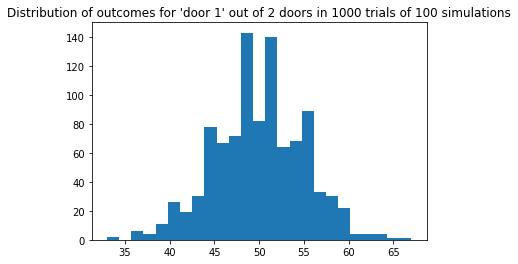

In [505]:
# histogram of samples of trials
pyplot.hist(run_monte['door 1'], bins=25)
pyplot.title('Distribution of outcomes for \'door 1\' out of 2 doors in 1000 trials of 100 simulations')

##### Case 2: Contestant Chooses Wrong, Monte Must Open the Only Door without the Car

If the contestant inially picks a door with the car, Monte faces some constraints, since now there is just one door he can open: the other door has the car. This occurs in 2/3 of cases, namely, those cases in which the contestant's initial guess was wrong. Now, if the contestant chooses to switch, they will certainly win the car. So in 2/3 of cases, when the contestant switches after a wrong guess, they always win the car! Of course, the contestant who does not switch loses in these 2/3 of cases.

### Simulate the Monte Hall Problem

Next we write a simulator that accounts for the above independent and conditional probabilities and distributions:

In [493]:
# Param 1 car_placement: list of tuples of door and whether that door has the car
# Param 2 car_door: the door with the car, e.g. 'door 1'
# Param 3 contestant_choice: the door initially chosen by the contestant, e.g. 'door 2'
# Returns: list of doors that Monte can open: doors without the car and not chosen by the contestant
# returns either a single door, if Monte has no choice, or two doors, if Monte has a choice
def doors_monte_can_open(car_placement, car_door, contestant_choice):
    return [t for t in car_placement if t[0] != contestant_choice and t[0] != car_door]

# Param do_switch: whether or not the contestant switches after Monte opens one door
# Returns: 'car' or 'goat'
# simulate car placement and initial contestant choice, Monte opening one of the unchosen doors,
# and the result of the contestants choice to switch or not to switch
def sim_game(do_switch):
    # set up the initial placement of the car
    car_placement = sim_door(door_probas)
    
    # retrieve the door that has the car, e.g. 'door 1', 'door 2', 'door 3'
    car_door = [t[0] for t in car_placement if t[1] == 1][0]

    # independently retrieve the door chosen by the contestant, e.g. 'door 1', 'door 2', 'door 3'
    contestant_choice = [t[0] for t in sim_door(door_probas) if t[1] == 1][0]

    # retrieve list of doors Monte can open based on car placement and contestant choice
    openable_doors = doors_monte_can_open(car_placement, car_door, contestant_choice)

    if len(openable_doors) > 1:
        # Contestant guessed right, Monte has a choice!
        monte_opens = [t[0] for t in sim_monte(monte_probas, openable_doors) if t[1] == 1][0]
    else:
        # Contestant guessed wrong, Monte must pick the only available door, the door without the car
        monte_opens = openable_doors[0]
    opened_door = monte_opens[0]

    # If contestant chooses to switch, they get the only unopened, unguessed door
    if do_switch:
        contestant_choice = \
            [t[0] for t in car_placement if t[0] != contestant_choice and t[0] != opened_door][0]

    # return True if contestant's choice matches the door with the car
    return 'car' if car_door == contestant_choice else 'goat'

# perform n trials of sim_game
def run_games(num_games, do_switch):
    return pd.Series(Counter([sim_game(do_switch) for i in range(0, num_games)]))

# derive m samples of n trials of sim_game
def run_samples(num_samples, num_games, do_switch):
    return pd.DataFrame([run_games(num_games, do_switch) for i in range(0, num_samples)])

Our simulation randomly assigns the car to a given door, then randomly chooses one of the doors, simulating the contestant's initial choice. Based on this initial choice, we then have Monte open one of the unchosen doors. Finally, based on the *do_switch* parameter, we return the prize won by the contestant, whether the contestant remains with their initial guess or chooses to switch to the door not opened by Monte. Possible prizes are 'car' or 'goat'.

### Case 1: Contestant Does NOT Switch

In the first case, after making an initial guess, the contestant does not switch after Monte opens one of the remaining doors. We run 10 samples of 100 trials in which the contestant does NOT switch with the following results:

In [494]:
# results of 10 samples of 100 trials
no_switch_samples = run_samples(NUMBER_OF_SAMPLES, GAMES_PER_SAMPLE, False)
no_switch_samples

,goat,car
0,66,34
1,61,39
2,61,39
3,71,29
4,68,32
5,59,41
6,69,31
7,73,27
8,59,41
9,69,31


We compute the mean number of times of winning a car vs. a goat out of 100 trials in case 1, where the contestant does NOT switch:

In [495]:
no_switch_samples_mean = no_switch_samples.mean()
no_switch_samples_mean

goat    65.6
car     34.4
dtype: float64

We compute the variance of the times of winning a car vs. a goat out of 100 trials in case 1, where the contestant does NOT switch:

In [496]:
no_switch_samples_var = no_switch_samples.var()
no_switch_samples_var

goat    26.933333
car     26.933333
dtype: float64

We plot the respective means of winning a car vs. a goat in case 1:

<BarContainer object of 2 artists>

Text(0.5, 0, 'Prizes')

Text(0, 0.5, 'Probability of Winning')

Text(0.5, 0.98, 'Probability of Winning a Car vs. a Goat When Contestant Does Not Switch')

Text(0.5, 1.0, '100 Games per Sample, 10 Samples')

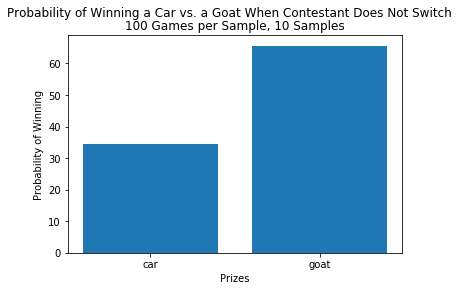

In [497]:
plt.bar(['car', 'goat'], [no_switch_samples_mean['car'], no_switch_samples_mean['goat']])
plt.xlabel('Prizes')
plt.ylabel('Probability of Winning')
plt.suptitle('Probability of Winning a Car vs. a Goat When Contestant Does Not Switch')
plt.title(str(GAMES_PER_SAMPLE) + ' Games per Sample, ' + str(NUMBER_OF_SAMPLES) + ' Samples')

Clearly, a contestant that remains with their initial choice is more likely to win a goat than a car.

We next examine the distribution of the probabilities of winning a car vs. a goat when not switching:

(array([2., 2., 0., 0., 0., 1., 1., 2., 1., 1.]),
 array([59. , 60.4, 61.8, 63.2, 64.6, 66. , 67.4, 68.8, 70.2, 71.6, 73. ]),
 <a list of 10 Patch objects>)

(array([1., 1., 2., 1., 0., 1., 0., 0., 2., 2.]),
 array([27. , 28.4, 29.8, 31.2, 32.6, 34. , 35.4, 36.8, 38.2, 39.6, 41. ]),
 <a list of 10 Patch objects>)

Text(0.5, 1.0, 'Frequency of winning a car vs. a goat in 10 samples of 100 trials WITHOUT switching')

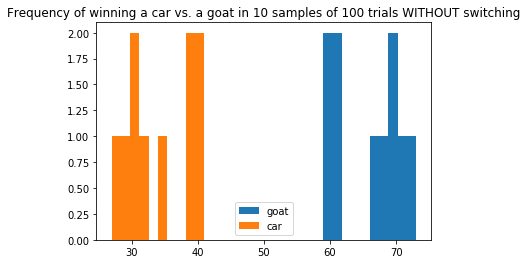

In [498]:
pyplot.hist(no_switch_samples['goat'], bins=10, label='goat')
pyplot.hist(no_switch_samples['car'], bins=10, label='car')
pyplot.legend()
pyplot.title('Frequency of winning a car vs. a goat in 10 samples of 100 trials WITHOUT switching')

### Case 2: Contestant Switches

In the second case, after making an initial guess, the contestant switches to the other unopened door after Monte opens one of the remaining doors. We run 10 samples of 100 trials in which the contestant DOES switch with the following results:

In [499]:
# results of 10 samples of 100 trials
switch_samples = run_samples(NUMBER_OF_SAMPLES, GAMES_PER_SAMPLE, True)
switch_samples

,car,goat
0,70,30
1,61,39
2,66,34
3,62,38
4,64,36
5,67,33
6,67,33
7,67,33
8,55,45
9,72,28


We compute the mean number of times of winning a car vs. a goat out of 100 trials in case 2, where the contestant DOES switch:

In [500]:
switch_samples_mean = switch_samples.mean()
switch_samples_mean

car     65.1
goat    34.9
dtype: float64

We compute the variance of the times of winning a car vs. a goat out of 100 trials in case 2, where the contestant DOES switch:

In [501]:
switch_samples_var = switch_samples.var()
switch_samples_var

car     23.655556
goat    23.655556
dtype: float64

<BarContainer object of 2 artists>

Text(0.5, 0, 'Prizes')

Text(0, 0.5, 'Probability of Winning')

Text(0.5, 0.98, 'Probability of Winning a Car vs. a Goat When Contestant Switches')

Text(0.5, 1.0, '100 Games per Sample, 10 Samples')

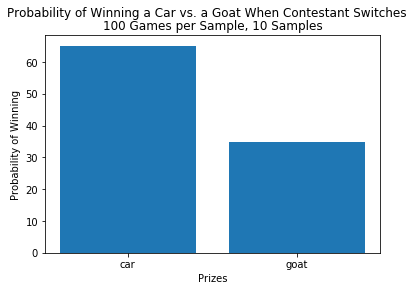

In [502]:
plt.bar(['car', 'goat'], [switch_samples_mean['car'], switch_samples_mean['goat']])
plt.xlabel('Prizes')
plt.ylabel('Probability of Winning')
plt.suptitle('Probability of Winning a Car vs. a Goat When Contestant Switches')
plt.title(str(GAMES_PER_SAMPLE) + ' Games per Sample, ' + str(NUMBER_OF_SAMPLES) + ' Samples')

Clearly, a contestant who switches from their initial choice is more likely to win a car.

We next examine the distribution of the probabilities of winning a car vs. a goat when switching:

(array([1., 1., 3., 1., 1., 1., 1., 0., 0., 1.]),
 array([28. , 29.7, 31.4, 33.1, 34.8, 36.5, 38.2, 39.9, 41.6, 43.3, 45. ]),
 <a list of 10 Patch objects>)

(array([1., 0., 0., 1., 1., 1., 1., 3., 1., 1.]),
 array([55. , 56.7, 58.4, 60.1, 61.8, 63.5, 65.2, 66.9, 68.6, 70.3, 72. ]),
 <a list of 10 Patch objects>)

Text(0.5, 1.0, 'Frequency of winning a car vs. a goat in 10 samples of 100 trials WITH switching')

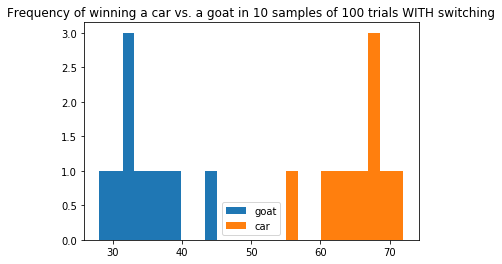

In [503]:
pyplot.hist(switch_samples['goat'], bins=10, label='goat')
pyplot.hist(switch_samples['car'], bins=10, label='car')
pyplot.legend()
pyplot.title('Frequency of winning a car vs. a goat in 10 samples of 100 trials WITH switching')

### Comparison of Cases

Comparison of cases in which the contestant switches or does not switch reveals that the contestant who switches is twice likely to win the car. The contestant who switches has roughly a 2/3 chance of winning the car versus the contestant who does not switch, who has roughly a 1/3 chance of winning the car.

As discussed above, the contestant who does not switch (case 1) has simply the expected 1 in 3 chance of guessing the door with the car. When Monte later opens a door, this clearly has no effect on their initial choice nor the probability of their success at winning the car.

The contestant who does switch (case 2), however, is able to leverage the information obtained after Monte opens one of the doors. Of course, if their initial selection was correct, they will lose by switching, which occurs in 1 of 3 cases. But in the remaining 2 of 3 cases, they always win, because Monte shows them which of the two remaining doors has the car. So the contestant who switches has a 2/3 chance of winning the car.

This analysis is confirmed by our simulation, which shows that in the first case, in which the contestant does not switch, the mean number of times they win out of 100 trials is about 33 percent, but in the second case, in which the contestant switches, the mean number of times they win out of 100 trials is about 67 percent.

### Recommended Strategy

Therefore, based on the above analysis of conditional probabilities and distributions as well as our simulation, the recommended strategy is to switch from our initial choice of doors to the remaining door after Monte opens one of the doors.